<a href="https://colab.research.google.com/github/Saadkhalid913/ML-Practice/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torchvision.transforms as transforms 
import torch.nn.functional as F 
import torch.nn as nn
import numpy as np
import os 
import matplotlib.pyplot as plt 
from PIL import Image
import google.colab.drive as drive 
from torch.utils.data import Dataset, dataloader
import torch
import tensorflow as tf 
import tqdm
from skimage.filters import threshold_multiotsu
import seaborn as sns
from sklearn.cluster import KMeans
import random


drive.mount("drive")

Mounted at drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# !mkdir ../root/.kaggle
# !cp drive/MyDrive/kaggle/kaggle.json ../root/.kaggle/kaggle.json

In [ ]:
import kaggle 

In [5]:
# !kaggle datasets download "dansbecker/cityscapes-image-pairs"


 98% 197M/202M [00:00<00:00, 235MB/s]
100% 202M/202M [00:00<00:00, 239MB/s]


In [ ]:
# !unzip cityscapes-image-pairs.zip

In [7]:

n_classes = 5
class UNETDataset(Dataset):

  def __init__(self):
    self.train_dir  = "cityscapes_data/train"
    self.image_names = next(os.walk(self.train_dir))[2][: 10000]
    self.number_of_images = len(self.image_names)
    self.km = None 
    self.k_classes = 8
    self.train_kmeans()

  def getSegmentationArr(self, image, width=256, height=256):
      seg_labels = np.zeros((self.k_classes, height, width))
      
      for c in range(self.k_classes):
          seg_labels[c, :, :] = (image == c).astype(int)
      return seg_labels

  def train_kmeans(self):
    colors = []
    images = []
    n_images = 15
    for i in range(n_images):
      images.append(self.get_mask(random.randint(0, len(self) - 1)))
    for image in images:
        colors.append(torch.reshape(image, (image.shape[1]*image.shape[2], 3)).numpy())
    colors = np.array(colors, dtype = float)

    colors = colors.reshape(n_images * colors.shape[1], 3)
    km = KMeans(self.k_classes)
    km.fit(colors)
    self.km = km 

  def EncodeImage(self, img: torch.tensor) -> torch.tensor:
    height = img.shape[1]
    width = img.shape[2]
    img = img.reshape(3, height * width).T
    output = self.km.predict(img)
    predicted_classes = output.reshape(height, width)
    return predicted_classes


  def __len__(self):
    return self.number_of_images

  def get_mask(self, index):
      image_name = self.image_names[index]
      image_data = Image.open(f"{self.train_dir}/{image_name}")

      tensor_transform = transforms.ToTensor()
      image_data = tensor_transform(image_data)

      mask = image_data[: , : , 256 : ]

      return  mask

  def __getitem__(self, index):
      image_name = self.image_names[index]
      image_data = Image.open(f"{self.train_dir}/{image_name}")

      tensor_transform = transforms.ToTensor()
      image_data = tensor_transform(image_data)

      img = image_data[: , : ,  : 256 ]
      mask = image_data[: , : , 256 : ]

      segmented_mask = self.EncodeImage(mask)
      segmented_mask = self.getSegmentationArr(segmented_mask)
      segmented_mask = torch.tensor(segmented_mask)

      return img.float(), segmented_mask.float(), mask.float()



In [8]:
batch_size = 16
train_set = UNETDataset()
train_loader = dataloader.DataLoader(train_set, batch_size = batch_size, shuffle = False)

In [9]:
img, mask, original = train_set[13]

In [10]:
print(mask.shape)

torch.Size([8, 256, 256])


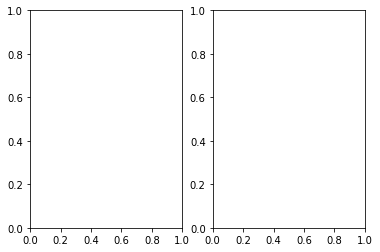

In [11]:
def ColorSegmentedImage(img):
  colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), 
              (0,255,255), (200,50,0),(50,200,0), (50,0,200), 
              (200,200,50), (0,50,200), (0,200,50), (0,0,0)]

  # colors = sns.color_palette("hls", img.shape[0])
  mask = np.zeros((3, 256,256), dtype = np.float32)

  for i in range(img.shape[0]):
    indices = (img[i] == 1)
    mask[0][indices] = colors[i][0]
    mask[1][indices] = colors[i][1]
    mask[2][indices] = colors[i][2]
  
  mask = mask/255.0
  return mask



fig, ax = plt.subplots(nrows = 1, ncols = 2)
# ax[0].imshow(ColorSegmentedImage(mask).transpose(1,2,0))
# ax[1].imshow(original.permute(1,2,0))



In [12]:
class UNET(nn.Module):
  def __init__(self):

    super().__init__()

    self.learning_rate = 5e-5

    # batch norm 

    self.Batch_Norm = nn.BatchNorm2d(num_features=3)

    ## L1
    self.conv_1_1 = nn.Conv2d(3, 64, 3, 1,padding = "same")
    self.conv_1_2 = nn.Conv2d(64, 64, 3, 1, padding = "same")
    self.dropout_1 = nn.Dropout2d(0.2)

    self.max_pool_1 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L2
    self.conv_2_1 = nn.Conv2d(64, 128, 3, 1,padding = "same")
    self.conv_2_2 = nn.Conv2d(128, 128, 3, 1, padding = "same")
    self.dropout_2 = nn.Dropout2d(0.2)

    self.max_pool_2 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L3
    self.conv_3_1 = nn.Conv2d(128,256, 3, 1,padding = "same")
    self.conv_3_2 = nn.Conv2d(256, 256, 3, 1, padding = "same")
    self.dropout_3 = nn.Dropout2d(0.2)

    self.max_pool_3 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L4
    self.conv_4_1 = nn.Conv2d(256, 512, 3, 1,padding = "same")
    self.conv_4_2 = nn.Conv2d(512, 512, 3, 1, padding = "same")
    self.dropout_4 = nn.Dropout2d(0.2)

    self.max_pool_4 = nn.MaxPool2d(kernel_size = 2, return_indices = True)

    ## L5
    self.conv_5_1 = nn.Conv2d(512, 1024, 1,padding = "same")
    self.conv_5_2 = nn.Conv2d(1024, 1024, 3, 1, padding = "same")
    self.dropout_5 = nn.Dropout2d(0.2)

    ##UP 1
    self.deconv1_1 = nn.ConvTranspose2d(1024, 512, 3, padding = 1, stride=2, output_padding = 1)
    self.deconv1_2 = nn.Conv2d(1024, 512, 3, 1, padding = "same")
    self.deconv1_3 = nn.Conv2d(512, 512, 3, 1, padding = "same")
    self.dropout_6 = nn.Dropout2d(0.2)


    ##UP 2
    self.deconv2_1 = nn.ConvTranspose2d(512, 256, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv2_2 = nn.Conv2d(512, 256, 3, 1, padding = "same")
    self.deconv2_3 = nn.Conv2d(256, 256, 3, 1, padding = "same")
    self.dropout_7 = nn.Dropout2d(0.2)


    ##UP 3
    self.deconv3_1 = nn.ConvTranspose2d(256, 128, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv3_2 = nn.Conv2d(256, 128, 3, 1, padding = "same")
    self.deconv3_3 = nn.Conv2d(128, 128, 3, 1, padding = "same")
    self.dropout_8 = nn.Dropout2d(0.2)


    ##UP 4
    self.deconv4_1 = nn.ConvTranspose2d(128, 64, 3, padding = 1, stride = 2, output_padding = 1)
    self.deconv4_2 = nn.Conv2d(128, 64, 3, 1, padding = 1)
    self.deconv4_3 = nn.Conv2d(64, 64, 3, 1, padding = "same")
    self.dropout_9 = nn.Dropout2d(0.2)


    ##UP 4
    self.deconv5_1 = nn.Conv2d(64, 64, 3, 1, padding = "same")
    self.deconv5_2 = nn.Conv2d(64, 8, 1, 1, padding = "same")







  def forward(self, x):
    x = self.Batch_Norm(x)
    L1_1 = self.conv_1_1(x)
    L1_1 = F.relu(L1_1)
    L1_2 = self.conv_1_2(L1_1)
    L1_2 = F.relu(L1_2)
    L1_2 = self.dropout_1(L1_2)


    L1_MAX, L1_indices = self.max_pool_1(L1_2)

    L2_1 = self.conv_2_1(L1_MAX)
    L2_1 = F.relu(L2_1)
    L2_2 = self.conv_2_2(L2_1)
    L2_2 = F.relu(L2_2)
    L2_2 = self.dropout_2(L2_2)

    L2_MAX, L2_indices = self.max_pool_2(L2_2)

    L3_1 = self.conv_3_1(L2_MAX)
    L3_1 = F.relu(L3_1)
    L3_2 = self.conv_3_2(L3_1)
    L3_2 = F.relu(L3_2)
    L3_2 = self.dropout_3(L3_2)

    L3_MAX, L3_indices = self.max_pool_3(L3_2)

    L4_1 = self.conv_4_1(L3_MAX)
    L4_1 = F.relu(L4_1)
    L4_2 = self.conv_4_2(L4_1)
    L4_2 = F.relu(L4_2)
    L4_2 = self.dropout_4(L4_2)

    L4_MAX, L4_indices = self.max_pool_4(L4_2)

    L5_1 = self.conv_5_1(L4_MAX)
    L5_1 = F.relu(L5_1)
    L5_2 = self.conv_5_2(L5_1)
    L5_2 = F.relu(L5_2)
    L5_2 = self.dropout_5(L5_2)

    ## Expansive Path

    D1_1 = self.deconv1_1(L5_2)
    skip_connection_1 = torch.cat([L4_2, D1_1], dim = 1)
    D1_2 = self.deconv1_2(skip_connection_1)
    D1_2 = F.relu(D1_2)
    D1_3 = self.deconv1_3(D1_2)
    D1_3 = F.relu(D1_3)
    D1_3 = self.dropout_6(D1_3)

    D2_1 = self.deconv2_1(D1_2)
    skip_connection_2 = torch.cat([L3_2, D2_1], dim = 1)
    D2_2 = self.deconv2_2(skip_connection_2)
    D2_2 = F.relu(D2_2)
    D2_3 = self.deconv2_3(D2_2)
    D2_3 = F.relu(D2_3)
    D2_3 = self.dropout_7(D2_3)

    D3_1 = self.deconv3_1(D2_2)
    skip_connection_3 = torch.cat([L2_2, D3_1], dim = 1)
    D3_2 = self.deconv3_2(skip_connection_3)
    D3_2 = F.relu(D3_2)
    D3_3 = self.deconv3_3(D3_2)
    D3_3 = F.relu(D3_3)
    D3_3 = self.dropout_8(D3_3)

    D4_1 = self.deconv4_1(D3_2)
    skip_connection_4 = torch.cat([L1_2, D4_1], dim = 1)
    D4_2 = self.deconv4_2(skip_connection_4)
    D4_2 = F.relu(D4_2)
    D4_3 = self.deconv4_3(D4_2)
    D4_3 = F.relu(D4_3)
    D4_3 = self.dropout_9(D4_3)

    D5_1 = self.deconv5_1(D4_2)
    D5_2 = self.deconv5_2(D5_1)
    D5_2 = torch.sigmoid(D5_2)



    return D5_2

In [13]:
NET = UNET()
NET = NET.to(device)
Optimizer = torch.optim.Adam(NET.parameters(), lr = NET.learning_rate)
Loss = nn.BCELoss()

EPOCHS = 5


In [14]:
losses_arr = []

In [ ]:
NET.train()
for epoch in range(EPOCHS):
  Epoch_loss = 0
  group_loss = 0
  for i, (x,y, original) in enumerate(train_loader):

    if (i % 10 == 0):
      print("Batch Number: ", i + 1, " / ", len(train_loader), " LOSS: " + str(group_loss))
      losses_arr.append(group_loss)
      group_loss = 0 
    

    x = x.to(device)
    y = y.to(device)

    output = NET(x)

    Optimizer.zero_grad()
    loss = Loss(output, y)
    loss.backward()
    Optimizer.step()

    Epoch_loss += loss.item()
    group_loss += loss.item()

  print(f"Epoch #{epoch + 1 } complete, LOSS: {Epoch_loss}")


In [17]:
torch.save(NET.state_dict(), "UNET_Cityscapes.weights")

In [30]:
class UNETDatasetTest(Dataset):

  def __init__(self):
    self.train_dir  = "cityscapes_data/val"
    self.image_names = next(os.walk(self.train_dir))[2]
    self.number_of_images = len(self.image_names)
    self.km = None 
    self.k_classes = 8
    self.train_kmeans()

  def getSegmentationArr(self, image, width=256, height=256):
      seg_labels = np.zeros((self.k_classes, height, width))
      
      for c in range(self.k_classes):
          seg_labels[c, :, :] = (image == c).astype(int)
      return seg_labels

  def train_kmeans(self):
    colors = []
    images = []
    n_images = 15
    for i in range(n_images):
      images.append(self.get_mask(random.randint(0, len(self) - 1)))
    for image in images:
        colors.append(torch.reshape(image, (image.shape[1]*image.shape[2], 3)).numpy())
    colors = np.array(colors, dtype = float)

    colors = colors.reshape(n_images * colors.shape[1], 3)
    km = KMeans(self.k_classes)
    km.fit(colors)
    self.km = km 

  def EncodeImage(self, img: torch.tensor) -> torch.tensor:
    height = img.shape[1]
    width = img.shape[2]
    img = img.reshape(3, height * width).T
    output = self.km.predict(img)
    predicted_classes = output.reshape(height, width)
    return predicted_classes


  def __len__(self):
    return self.number_of_images

  def get_mask(self, index):
      image_name = self.image_names[index]
      image_data = Image.open(f"{self.train_dir}/{image_name}")

      tensor_transform = transforms.ToTensor()
      image_data = tensor_transform(image_data)

      mask = image_data[: , : , 256 : ]

      return  mask

  def __getitem__(self, index):
      image_name = self.image_names[index]
      image_data = Image.open(f"{self.train_dir}/{image_name}")

      tensor_transform = transforms.ToTensor()
      image_data = tensor_transform(image_data)

      img = image_data[: , : ,  : 256 ]
      mask = image_data[: , : , 256 : ]

      segmented_mask = self.EncodeImage(mask)
      segmented_mask = self.getSegmentationArr(segmented_mask)
      segmented_mask = torch.tensor(segmented_mask)

      return img.float(), segmented_mask.float(), mask.float()



In [32]:
testset = UNETDatasetTest()


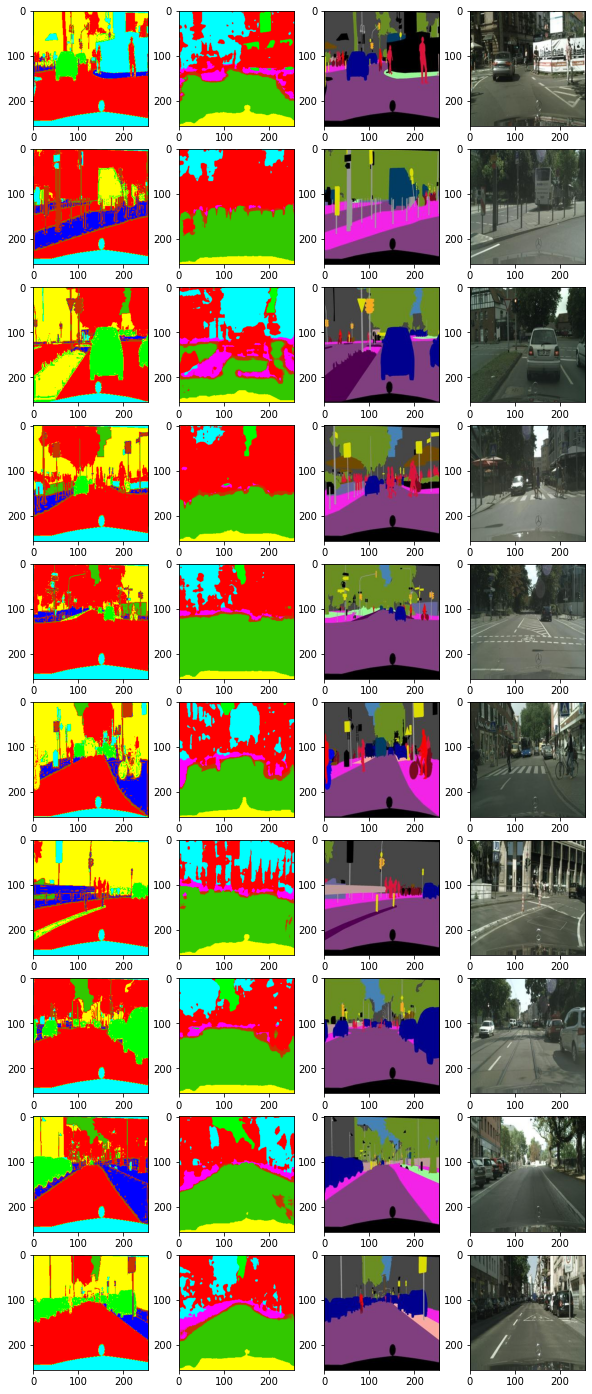

In [165]:
NET.eval()
fig, ax = plt.subplots(nrows = 10, ncols = 4)
fig.set_figheight(25)
fig.set_figwidth(10)

for run in range(10):
  image_index = np.random.randint(100,500)
  img, seg_mask, mask = testset[image_index]
  img = img.unsqueeze(dim = 0)
  img = img.to(device)

  pred = NET(img)
  pred = pred.squeeze()
  pred_indices = torch.argmax(pred, dim = 0)
  segmented_image = testset.getSegmentationArr(pred_indices.cpu().numpy())


  # for i in range(256):
  #   for j in range(256):
  #     index = pred_indices[i,j]
  #     predicted_segmentation[[index], i,j] = 1

  img = img.squeeze().cpu()


  ax[run, 0].imshow(ColorSegmentedImage(seg_mask).transpose(1,2,0))
  ax[run, 1].imshow(ColorSegmentedImage(segmented_image).transpose(1,2,0))
  ax[run, 2].imshow(mask.permute(1,2,0))
  ax[run, 3].imshow(img.permute(1,2,0))


In [166]:
new_losses = []
for i in losses_arr:
  if i > 0:
    new_losses.append(i)

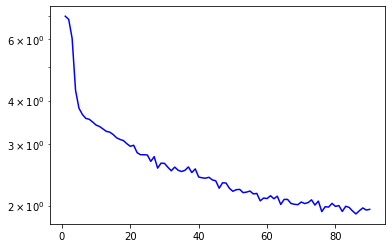

In [167]:
plt.plot(np.arange(1, len(new_losses) + 1), new_losses, color = "blue")
plt.yscale("log")
plt.show()